# Cointegration Tests

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from time import time
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

import numpy as np
from numpy.linalg import LinAlgError

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [4]:
DATA_PATH = Path('..', 'data')
STORE = DATA_PATH / 'assets.h5'

### Johansen Test Critical Values

In [5]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [6]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load & Clean Stock & ETF Data

### Remove highly correlated assets

In [7]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

### Remove stationary series

In [8]:
def check_stationarity(df):
    results = []
    for ticker, prices in df.items():
        results.append([ticker, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

In [9]:
def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'ticker'].tolist()
    return df.drop(stationary, axis=1).sort_index()

### Select Assets

In [10]:
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore(STORE) as store:
        df = (pd.concat([
            store[f'stooq/us/nasdaq/{asset_class}/prices'],
            store[f'stooq/us/nyse/{asset_class}/prices']
        ]).sort_index().loc[idx[:, str(start):str(end)], :])
        df = df.reset_index().drop_duplicates().set_index(['ticker', 'date'])
        df['dv'] = df.close.mul(df.volume)
        dv = df.groupby(level='ticker').dv.mean().nlargest(n=n).index
        df = (df.loc[idx[dv, :],
                     'close'].unstack('ticker').ffill(limit=5).dropna(axis=1))

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

In [11]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
    df.to_hdf('data.h5', f'{asset_class}/close')

### Get ticker dictionary

In [12]:
def get_ticker_dict():
    with pd.HDFStore(STORE) as store:
        return (pd.concat([
            store['stooq/us/nyse/stocks/tickers'],
            store['stooq/us/nyse/etfs/tickers'],
            store['stooq/us/nasdaq/etfs/tickers'],
            store['stooq/us/nasdaq/stocks/tickers']
        ]).drop_duplicates().set_index('ticker').squeeze().to_dict())

In [13]:
names = get_ticker_dict()

## Visualize Correlation Clusters 

In [14]:
stocks = pd.read_hdf('data.h5', 'stocks/close')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AA.US to YUM.US
dtypes: float64(172)
memory usage: 3.3 MB


In [15]:
etfs = pd.read_hdf('data.h5', 'etfs/close')
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 139 entries, AAXJ.US to YCS.US
dtypes: float64(139)
memory usage: 2.7 MB


In [16]:
tickers = {k: v for k, v in names.items() if k in etfs.columns.union(stocks.columns)}
pd.Series(tickers).to_hdf('data.h5', 'tickers')

In [17]:
corr = pd.DataFrame(index=stocks.columns)
for etf, data in etfs.items():
    corr[etf] = stocks.corrwith(data)

In [18]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, AA.US to YUM.US
Columns: 139 entries, AAXJ.US to YCS.US
dtypes: float64(139)
memory usage: 193.1+ KB


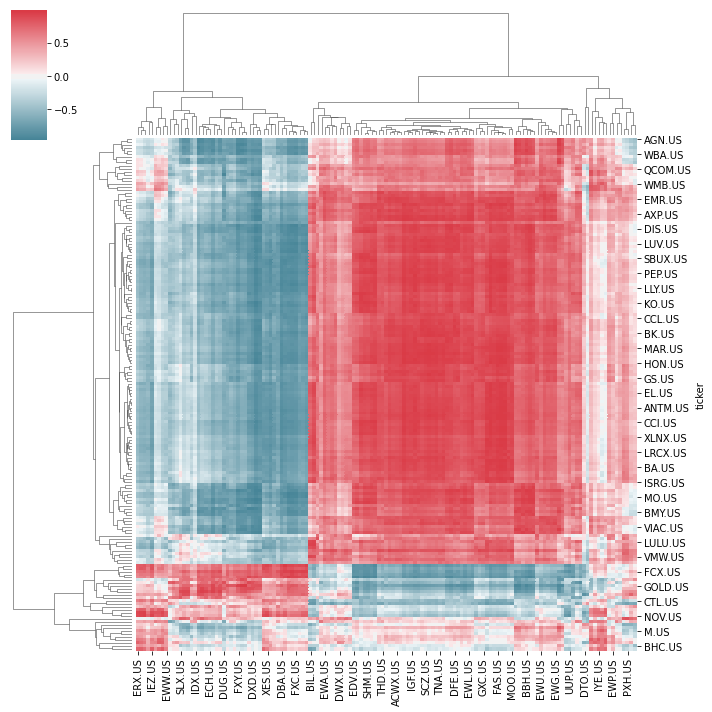

In [19]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(corr, cmap=cmap, center=0);

## Candidate Selection using Heuristics

### Computational Complexity: Comparing running times

In [20]:
stocks.shape, etfs.shape

((2516, 172), (2516, 139))

In [21]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AA.US to YUM.US
dtypes: float64(172)
memory usage: 3.3 MB


In [22]:
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 139 entries, AAXJ.US to YCS.US
dtypes: float64(139)
memory usage: 2.7 MB


In [23]:
security = etfs['AAXJ.US'].loc['2010': '2013']
candidates = stocks.loc['2010': '2013']

In [24]:
security = security.div(security.iloc[0])
candidates = candidates.div(candidates.iloc[0])
spreads = candidates.sub(security, axis=0)

In [25]:
n, m = spreads.shape
X = np.ones(shape=(n, 2))
X[:, 1] = np.arange(1, n+1)

#### Heuristics

In [26]:
%%timeit
np.linalg.inv(X.T @ X) @ X.T @ spreads

470 µs ± 6.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
%%timeit
spreads.std()

1.16 ms ± 9.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
%%timeit
candidates.corrwith(security)

27.8 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Cointegration Tests

In [30]:
%%timeit
for candidate, prices in candidates.items():
    df = pd.DataFrame({'s1': security,
                       's2': prices})
    var = VAR(df.values)
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']
    coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
    coint(security, prices, trend='c')[:2]
    coint(prices, security, trend='c')[:2]

13.1 s ± 2.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Compute Heuristics

In [33]:
def compute_pair_metrics(security, candidates):
    security = security.div(security.iloc[0])
    ticker = security.name
    candidates = candidates.div(candidates.iloc[0])
    spreads = candidates.sub(security, axis=0)
    n, m = spreads.shape
    X = np.ones(shape=(n, 2))
    X[:, 1] = np.arange(1, n + 1)
    drift = ((np.linalg.inv(X.T @ X) @ X.T @ spreads).iloc[1]
             .to_frame('drift'))
    vol = spreads.std().to_frame('vol')
    corr_ret = (candidates.pct_change()
                .corrwith(security.pct_change())
                .to_frame('corr_ret'))
    corr = candidates.corrwith(security).to_frame('corr')
    metrics = drift.join(vol).join(corr).join(corr_ret).assign(n=n)
    tests = []
    for candidate, prices in candidates.items():
        df = pd.DataFrame({'s1': security, 's2': prices})
        var = VAR(df.values)
        lags = var.select_order() # select VAR order
        k_ar_diff = lags.selected_orders['aic']
        # Johansen Test with constant Term and estd. lag order
        cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
        # Engle-Granger Tests
        t1, p1 = coint(security, prices, trend='c')[:2]
        t2, p2 = coint(prices, security, trend='c')[:2]
        tests.append([ticker, candidate, t1, p1, t2, p2, 
                      k_ar_diff, *cj0.lr1])
    columns = ['s1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1']
    tests = pd.DataFrame(tests, columns=columns).set_index('s2')
    return metrics.join(tests)

In [34]:
spreads = []
start = 2010
stop = 2019
etf_candidates = etfs.loc[str(start): str(stop), :]
stock_candidates = stocks.loc[str(start): str(stop), :]
s = time()
for i, (etf_ticker, etf_prices) in enumerate(etf_candidates.items(), 1):
    df = compute_pair_metrics(etf_prices, stock_candidates)
    spreads.append(df.set_index('s1', append=True))
    if i % 10 == 0:
        print(f'{i:>3} {time() - s:.1f}')
        s = time()

 10 313.9
 20 391.3
 30 409.8
 40 411.2
 50 407.6
 60 403.9
 70 412.0
 80 409.4
 90 411.1
100 422.4
110 405.4
120 406.2
130 406.1


In [35]:
names = get_ticker_dict()
spreads = pd.concat(spreads)
spreads.index.names = ['s2', 's1']
spreads = spreads.swaplevel()
spreads['name1'] = spreads.index.get_level_values('s1').map(names)
spreads['name2'] = spreads.index.get_level_values('s2').map(names)

In [36]:
spreads['t'] = spreads[['t1', 't2']].min(axis=1)
spreads['p'] = spreads[['p1', 'p2']].min(axis=1)

### Engle-Granger vs Johansen: how do their findings compare?

In [37]:
spreads['trace_sig'] = ((spreads.trace0 > trace0_cv) &
                        (spreads.trace1 > trace1_cv)).astype(int)
spreads['eg_sig'] = (spreads.p < .05).astype(int)

In [38]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,21645,749
1,1353,161


In [39]:
spreads['coint'] = (spreads.trace_sig & spreads.eg_sig).astype(int)

In [40]:
spreads.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23908 entries, ('AAXJ.US', 'AA.US') to ('YCS.US', 'YUM.US')
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   drift      23908 non-null  float64
 1   vol        23908 non-null  float64
 2   corr       23908 non-null  float64
 3   corr_ret   23908 non-null  float64
 4   n          23908 non-null  int64  
 5   t1         23908 non-null  float64
 6   p1         23908 non-null  float64
 7   t2         23908 non-null  float64
 8   p2         23908 non-null  float64
 9   k_ar_diff  23908 non-null  int64  
 10  trace0     23908 non-null  float64
 11  trace1     23908 non-null  float64
 12  name1      23908 non-null  object 
 13  name2      23908 non-null  object 
 14  t          23908 non-null  float64
 15  p          23908 non-null  float64
 16  trace_sig  23908 non-null  int64  
 17  eg_sig     23908 non-null  int64  
 18  coint      23908 non-null  int64  
dtypes: float64(1

In [41]:
spreads = spreads.reset_index()

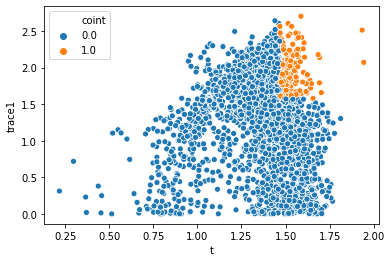

In [42]:
sns.scatterplot(x=np.log1p(spreads.t.abs()), 
                y=np.log1p(spreads.trace1), 
                hue='coint', data=spreads[spreads.trace0>trace0_cv]);

In [43]:
spreads.to_hdf('heuristics.h5', 'spreads')

In [44]:
spreads = pd.read_hdf('heuristics.h5', 'spreads')

### Evaluate Heuristics

In [45]:
spreads.drift = spreads.drift.abs()

In [46]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,21645,749
1,1353,161


In [47]:
pd.set_option('display.float_format', lambda x: f'{x:.2%}')
pd.crosstab(spreads.eg_sig, spreads.trace_sig, normalize=True)

trace_sig,0,1
eg_sig,,
0,90.53%,3.13%
1,5.66%,0.67%


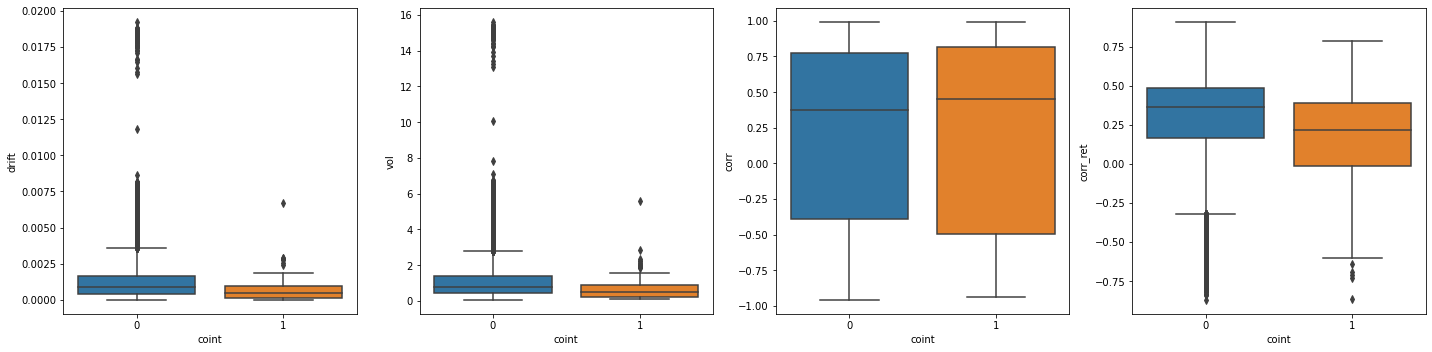

In [49]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i, heuristic in enumerate(['drift', 'vol', 'corr', 'corr_ret']):
    sns.boxplot(x='coint', y=heuristic, data=spreads, ax=axes[i])
fig.tight_layout();

### How well do the heuristics predict significant cointegration?

In [50]:
spreads.groupby(spreads.coint)['drift', 'vol', 'corr'].describe().stack(level=0).swaplevel().sort_index()

25%    50%     75%       count      max    mean     min  \
      coint                                                               
corr  0     -38.88% 37.10%  77.53% 2374700.00%   99.17%  20.61% -95.88%   
      1     -49.28% 45.31%  81.63%   16100.00%   99.07%  20.13% -93.50%   
drift 0       0.04%  0.09%   0.17% 2374700.00%    1.92%   0.13%   0.00%   
      1       0.01%  0.05%   0.10%   16100.00%    0.67%   0.07%   0.00%   
vol   0      46.08% 80.12% 139.56% 2374700.00% 1560.03% 117.39%   5.77%   
      1      24.79% 51.40%  87.97%   16100.00%  561.25%  70.22%   8.10%   

                std  
      coint          
corr  0      60.70%  
      1      66.96%  
drift 0       0.18%  
      1       0.08%  
vol   0     145.64%  
      1      68.08%

In [51]:
spreads.coint.value_counts()

0    23747
1      161
Name: coint, dtype: int64

#### Logistic Regression

In [52]:
y = spreads.coint
X = spreads[['drift', 'vol', 'corr', 'corr_ret']]
# X = spreads[['drift', 'vol']]

In [53]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [54]:
log_reg = LogisticRegressionCV(Cs=np.logspace(-10, 10, 21), 
                               class_weight='balanced',
                               scoring='roc_auc')

'C:-10.00, AUC: 64.75%'

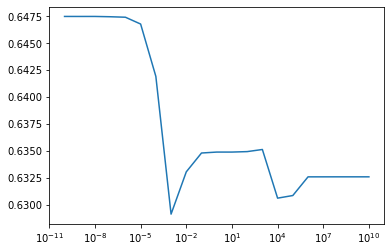

In [55]:
log_reg.fit(X=X, y=y)
Cs = log_reg.Cs_
scores = pd.DataFrame(log_reg.scores_[True], columns=Cs).mean()
scores.plot(logx=True);
f'C:{np.log10(scores.idxmax()):.2f}, AUC: {scores.max():.2%}'

In [56]:
log_reg.coef_

array([[-3.51826270e-10, -2.81917597e-07, -2.87355303e-09,
        -7.30577702e-08]])

In [57]:
y_pred = log_reg.predict_proba(X)[:, 1]
confusion_matrix(y_true=spreads.coint, y_pred=(y_pred>.5))

array([[23747,     0],
       [  161,     0]])

In [58]:
spreads.assign(y_pred=log_reg.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

,count,mean,std,min,25%,50%,75%,max
coint,,,,,,,,
0,2374700.00%,50.00%,0.00%,50.00%,50.00%,50.00%,50.00%,50.00%
1,16100.00%,50.00%,0.00%,50.00%,50.00%,50.00%,50.00%,50.00%


#### Decision Tree Classifier

In [59]:
model = DecisionTreeClassifier(class_weight='balanced')
decision_tree = GridSearchCV(model,
                             param_grid={'max_depth': list(range(1, 10))},
                             cv=5,
                             scoring='roc_auc')

In [60]:
decision_tree.fit(X=X, y=y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

In [61]:
f'{decision_tree.best_score_:.2%}, Depth: {decision_tree.best_params_["max_depth"]}'

'60.63%, Depth: 3'

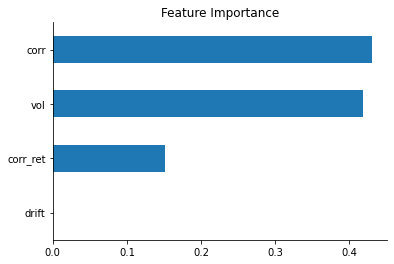

In [65]:
pd.Series(data=decision_tree.best_estimator_.feature_importances_, 
          index=X.columns).sort_values().plot.barh(title='Feature Importance')
sns.despine();

In [63]:
spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

,count,mean,std,min,25%,50%,75%,max
coint,,,,,,,,
0,2374700.00%,35.49%,17.34%,0.00%,31.45%,31.45%,31.45%,97.15%
1,16100.00%,64.51%,27.09%,31.45%,31.45%,68.79%,86.26%,97.15%


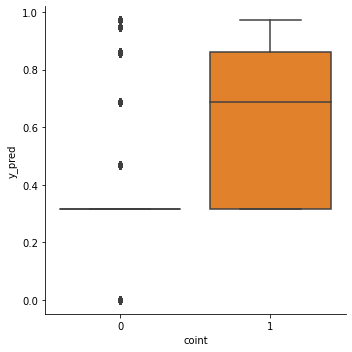

In [64]:
sns.catplot(x='coint', 
            y='y_pred', 
            data=spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]), 
            kind='box');